# Custom Distributions based on Flax Neural Networks in PyMC

Leaning on an applied data-analysis problem in the cognitive modeling space, this post develops the tools to use neural networks trained with the Flax package (a neural network library based on JAX) as approximate likelihoods in likelihood-free inference scenarios. We will spend some time setting up the data analysis problem first, including the modeling framework used and computational bottlenecks that may arise (however if you don't care about the particulars, feel free to skip this part). Then, step by step, we will develop the tools necessary to go from a simple data simulator without access to a likelihood function to Bayesian Inference with PyMC via a custom distribution. 

We will try to keep the code as general as possible, to facilitate other use cases with minimal hassle.

## Table of Contents
* [Setting the Stage](#setting_the_stage)
    * [The Data Analysis Problem](#data_analysis_problem)
        * [What kind of Data?](#kind_of_data)
        * [The model(s)](#the_models)
        * [Motivating likelihood free inference](#motivating_lfi)
* [From model simulation to PyMC model](#towards_pymc)
    * [Simulating Data](#data_simulation)
    * [Turning it into Training Data](#training_data)
    * [Building and Training the Network](#build_and_train)
    * [Connecting to PyMC](#pymc)
        * [Building a custom distribution](#custom_distribution)
        * [Plug the custom distribution into a PyMC model](#pymc_model)
        * [Inference example](#inference_example)

## Setting the Stage <a class="anchor" id="setting_the_stage"></a>

To motivate the modeling effort expounded upon below, let's start by building the case for a particular class of models, beginning with an (somewhat stylized) original data analysis problem.

Consider a dataset from the [NeuroRacer](https://www.nature.com/articles/nature12486) experiment, illustrated below with an adapted figure from the original paper.

![NeuroRacer](neuroracer_exp.png)


The *player/subject* in this experiment is tasked with steering a racing car along a curvy racetrack, while reacting appropriately to appearing traffic signs under time pressure. Traffic signs are either of the **target** or **no target** type, the players' reaction appropriately being a **button press** or **no button press** respectively. 

In the lingo of cognitive scientists, we may consider this game a Go / NoGo type task (press or withhold depending on traffic sign), under extra cognitive load (steering the car across the racetrack). 

This leaves us with **four types of responses** to analyse (see the figure below):
1. Correct button press (Correct Go)
2. Correct withhold (Correct NoGo)
3. False button press (False Go)
4. False withhold (False NoGo)


![Responsetypes](four_response_types.png)

### What kind of data <a class="anchor" id="kind_of_data"></a>

Collecting *reaction times* (rt) and *choices* (responses) for each of the trials, our dataset will eventually look as follows.

In [3]:
import numpy as np
import pandas as pd

# Generate example data
data = pd.DataFrame(np.random.uniform(size = (100,1)), columns = ['rt'])
data['response'] = 'go'
data['response'].values[int(data.shape[0] / 2):] = 'nogo'
data['trial_type'] = 'target'
data['trial_type'].values[int(data.shape[0] / 2):] = 'notarget'

data

,rt,response,trial_type
0,0.027364,go,target
1,0.182811,go,target
2,0.765755,go,target
3,0.738696,go,target
4,0.781853,go,target
...,...,...,...
95,0.143923,nogo,notarget
96,0.491977,nogo,notarget
97,0.583846,nogo,notarget
98,0.145585,nogo,notarget


### The model(s) <a class="anchor" id="the_models"></a>

Cognitive scientists have powerful framework for the joint analysis of **reaction time** and **choice** data: Sequential Sampling Models (SSMs). 

The canonical model in this framework is the [Drift Diffusion Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) (or Diffusion Decision Model). We will take this model as a starting point to explain how it applies to the analysis of [NeuroRacer](https://www.nature.com/articles/nature12486) data. 

The basic idea behind the [Drift Diffusion Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) is the following. 
We represent the decision process between two options as a Gaussian random walk of a so-called *evidence state*. This random walk initiates from a given starting point (parameter $z$), and evolves, with perturbed by Gaussian noise, according to a deterministic drift (parameter $v$), until it reaches one of two boundaries (the parameter $a$ specifies the distance between these boundaries).

*Which bound* is reached, and the *time of crossing*, jointly determine the reaction time and choice. Hence, this model specifies a *stochastic data generating process* and we can define a (potentially hard to derive, but more on this later) likelihood function for this.

We don't need to bother with analytical details of this likelihood function, since we will adopt an approximation approach in this tutorial which bypasses analytics by design. Let's first look at an illustration of the model and identify the quantities relevant for our example.


![DDM Likelihood](ddm_example_with_likelihoods.png)


The two quantities we will make explicit in the analyses are the following are,

1. $f_{Go}(t|v,a,z,ndt)$, the likelihood of observing a **Go** choice at time $t$
2. $p(choice = NoGo)$, the likelihood of "observing" a withheld button press (defined as the integral of $f_{NoGo}(t|v,a,z,ndt)$ over $t$

We will focus on a simple analysis case, in which we observe hypothetical data from a single player, who plays the game for $1000$, $500$ of which are **Go** trials (the traffic sign warrants a button press) and $500$ of which are **NoGo** trials (the traffic sign warrants withholding a button press.

Moreover, we make a simple modeling assumption. While we estimate only a single $v_{Go}$ parameter, we assume that for a **NoGo** trial the sign of the evidence increment changes (we accumulate evidence in favor of withholding instead of accumulating evidence in favor of a button press). Hence, $v_{NoGo} = - v_{Go}$. 

### Motivating Simulation Based Inference <a class="anchor" id="motivating_lfi"></a>


The Diffusion Decision Model does in fact have an (cumbersome) [analytical likelihood](https://philpapers.org/rec/FELAIT-4), with specialized [algorithms](https://psycnet.apa.org/record/2009-11068-003) for fast evaluation. There are however many interesting variants for which fast computations are hampered by a lack thereof (see for example [here](https://pyddm.readthedocs.io/en/stable/) and [here](https://elifesciences.org/articles/65074)).

On the other hand simulators for such variants tend to remain easy to code up (often a few lines in python do the job). 
A simulator but no likelihood? Welcome to the world of [**simulation based inference**](https://www.pnas.org/doi/10.1073/pnas.1912789117) (SBI).

Surveying the field of SBI is beyond the scope of this blog post (the paper above is a good start for those interested), but let it be said that SBI is the overarching paradigm from which we pick a specific [method](https://elifesciences.org/articles/65074) to construct our approach below.

The idea is the following. We start with a simulator for the DDM from which, given a set of parameters ($v$, $a$, $z$, $ndt$) we can construct empirical likelihood  functions for both $f_{Go}(t|v,a,z,ndt)$ and $p(choice=Nogo|v,a,z,ndt)$. For $f_{Go}(t|v,a,z,ndt)$ we construct smoothed histograms (or [Kernel Density Estimates](https://en.wikipedia.org/wiki/Kernel_density_estimation)), while for $p(choice=Nogo|v,a,z,ndt)$ we simply collect the respective choice probability from simulation runs. 

From these building blocks, we will construct training data to train two [Multilayer Perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLPs, read: small Neural Networks), one for each of the two parts of the overall likelihood.

These MLPs are going to act as our likelihood functions. We will call the network which represents $f_{Go}(t|v,a,z,ndt)$ a LAN, for Likelihood Approximation Network. The network for $p(choice=NoGo|v,a,z,ndt)$ will be called a CPN, for Choice Probability Network. As we will see later, can then evaluate our data-likelihood via forward passes through the LAN and CPN.

We will then proceed by wrapping these trained networks into a custom PyMC distribution and finally get samples from our posterior of interest $p(v,a,z,ndt|x)$ via the [Blackjax](https://github.com/blackjax-devs/blackjax) NUTS sampler, completing our walkthrough.

With all these steps ahead, let's get going!

## From model simulation to PyMC model  <a class="anchor" id="towards_pymc"></a>

### Simulating Data  <a class="anchor" id="data_simulation"></a>

In favor is a digestible reading experience, we will use a convenience package to simulate data from the DDM model.
This package not only allows us to simulate trajectories, but also includes utilities to directly produce data in a format suitable for downstream neural network training (which is our target here). The mechanics behind training data generation are described in [this paper](https://elifesciences.org/articles/65074).

For some intuition, let's start with simulating and plotting a simple collection of $1000$ DDM trajectories, setting the parameters $\{v,a,z,ndt\}$ as $\{1.0 , 1.5, 0.5, 0.5\}$.

In [4]:
from ssms.basic_simulators import simulator

n_trajectories = 1000
parameter_vector = np.array([1.0, 1.5, 0.5, 0.5])

simulation_data = simulator(model = 'ddm',
                            theta = parameter_vector,
                            n_samples = n_trajectories)

simulation_data.keys()

dict_keys(['rts', 'choices', 'metadata'])

The simulator returns a `dictionary` with three keys.

1. `rts`, the reaction times for each choice under 2.
2. `choices`, here coded as $-1$ for lower boundary crossings and $1$ for upper boundary crossings.
3. `metadata`, extra information about the simulator settings

Let's use this to plot the reaction time distribution (negative reals refer to $-1$ choices) and choice probabilities.
I will plot this for a few parameter settings to give some intuition about how the model behaves in response. Specifically we will vary the $v$ parameter, holding all other parameters constant the values reported above.

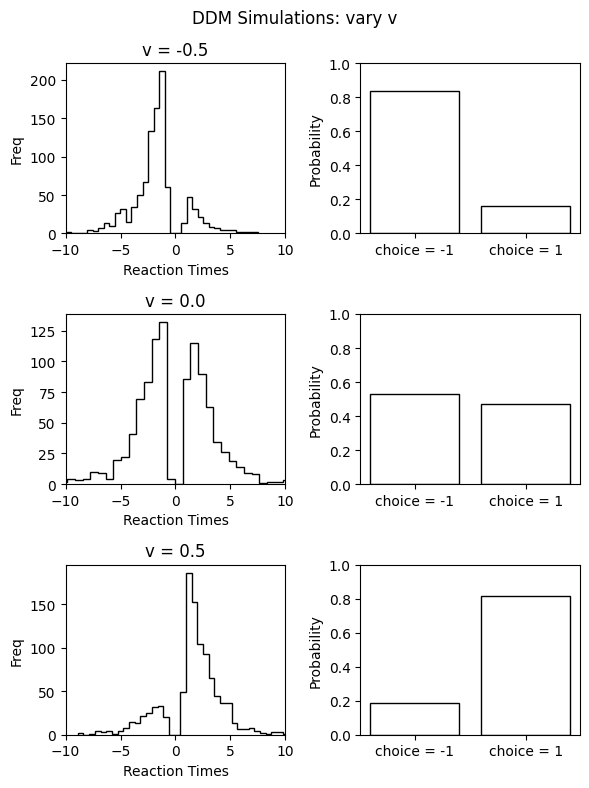

In [5]:
from matplotlib import pyplot as plt
parameter_matrix = np.zeros((3, 4))

# vary the first parameter across rows (the 'v' parameter in our case')
parameter_matrix[:, 0] = np.linspace(-0.5, 0.5, 3)

# set the rest to the values used above
for i in range(1, 4, 1):
    parameter_matrix[:, i] = parameter_vector[i]
    
# Make Figure
fig, axs = plt.subplots(3,2, figsize = (6, 8))
fig.suptitle('DDM Simulations: vary v')
for i in range(3):
    simulation_data_tmp = simulator(model = 'ddm',
                                theta = parameter_matrix[i, :],
                                n_samples = n_trajectories)
    for j in range(2):
        if j == 0:
            # Reaction Times + Choices
            axs[i, j].hist(np.squeeze(simulation_data_tmp['rts']) * np.squeeze(simulation_data_tmp['choices']),
                       histtype = 'step',
                       color = 'black',
                       bins = 40,
                       )
            axs[i, j].set_title('v = ' + str(round(parameter_matrix[i, 0], 2)))
            axs[i, j].set_xlim(-10, 10)
            axs[i, j].set_xlabel('Reaction Times')
            axs[i, j].set_ylabel('Freq')
            axs[i, j]
        else: 
            # Choice probabilities
            p_up = np.sum(simulation_data_tmp['choices'] == 1.) / n_trajectories
            choice_ps = [1 - p_up, p_up]
            axs[i, j].bar(['choice = -1', 'choice = 1'], choice_ps, fill = None)
            axs[i, j].set_ylabel('Probability')
            axs[i, j].set_ylim(0, 1)
fig.tight_layout()
plt.show()

### Turning it into Training Data  <a class="anchor" id="training_data"></a>

We will now use a couple of convenience function from the [`ssms`](https://github.com/AlexanderFengler/ssms) package, to generate training data for our Neural Networks.
This will proceed in *two* steps. We first define two config dictionaries to specify properties of the simulation runs that will serve as the basis for our training data set. 

1. The `generator_config` which specifies how to construct training data on top of basic simulations runs
2. The `model_config` which specifies the properties of the core simulator

Second, we will actually run the necessary simulations. 

Let's make the config dictionaries.

In [6]:
# MAKE CONFIGS
from ssms.config import data_generator_config
from ssms.config import model_config
from copy import deepcopy

# Generator Config

# (We start from a supplied example in the ssms package)
ddm_generator_config = deepcopy(data_generator_config['lan']) 

# Specify generative model (one from the list of included models in the ssms package)
ddm_generator_config['dgp_list'] = 'ddm'

# Specify number of parameter sets to simulate
ddm_generator_config['n_parameter_sets'] = 1000

# Specify how many samples a simulation run should entail
ddm_generator_config['n_samples'] = 1000

# Specify how many training examples to extract from 
# a single parameter vector
ddm_generator_config['n_training_samples_by_parameter_set'] = 500

# Specify folder in which to save generated data
ddm_generator_config['output_folder'] = 'data/training_data/ddm'

# Model Config
ddm_model_config = model_config['ddm']

We are now in the position to actually run the simulations.  

If you run this by yourself, 

1. Be aware that the next cell may run for a while (between a few minutes and an hour)
2. Make sure the `output_folder` specified above exists.

In [5]:
# MAKE DATA
from ssms.dataset_generators import data_generator
n_datasets = 10

my_dataset_generator = data_generator(generator_config = ddm_generator_config,
                                      model_config = ddm_model_config)

for i in range(n_datasets):
    print('Dataset: ', i + 1, ' of ', n_datasets)
    training_data = my_dataset_generator.generate_data_training_uniform(save = True)

n_cpus used:  32
checking:  data/training_data/ddm
Dataset:  1  of  10
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/training_data/ddm/training_data_78f469aead7911eda25ca0423f39b436.pickle
Dataset:  2  of  10
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/training_data/ddm/training_data_803fe314ad7911eda25ca0423f39b436.pickle
Dataset:  3  of  10
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  o

Now that we have our training datasets, we preprocess the training data by turning it into a `DataLoader` object. 
The `DataLoader` is supposed take care of:

1. Efficiently *reading in datafiles* and 
2. *turning them into batches* to be ingested when training a Neural Network. 

As has become somewhat of a standard, will work off of the `Dataset` class supplied by the `torch.utils.data` module in the  **PyTorch** deep learning framework.


The key methods to define in our custom dataset are `__getitem__()` and `__len__()`. 

`__len__()` helps us to understand the amount of batches contained in a complete run through the data (*epoch* in machine learning lingo). `__getitem_()` is the method called to retrieve the next batch of data.

Let's construct it. 

In [7]:
import torch
class DatasetTorch(torch.utils.data.Dataset):
    def __init__(self,
                 file_ids,
                 batch_size = 32,
                 label_lower_bound = None,
                 features_key = 'data',
                 label_key = 'labels',
                 ):
        
        # Initialization
        self.batch_size = batch_size
        self.file_ids = file_ids
        self.indexes = np.arange(len(self.file_ids))
        self.label_lower_bound = label_lower_bound
        self.features_key = features_key
        self.label_key = label_key
        self.tmp_data = None

        # Get metadata from loading a test file
        self.__init_file_shape()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor((len(self.file_ids) * ((self.file_shape_dict['inputs'][0] // self.batch_size) * self.batch_size)) / self.batch_size))

    def __getitem__(self, index):
        # Check if it is time to load the next file from disk
        if index % self.batches_per_file == 0 or self.tmp_data == None:
            self.__load_file(file_index = self.indexes[index // self.batches_per_file])

        # Generate batch_ids
        batch_ids = np.arange(((index % self.batches_per_file) * self.batch_size), 
                              ((index % self.batches_per_file) + 1) * self.batch_size, 1)
        
        # Make corresponding batch
        X = self.tmp_data[self.features_key][batch_ids, :]
        y = np.expand_dims(self.tmp_data[self.label_key][batch_ids], axis = 1)
        
        # Apply lower bound on labels
        if self.label_lower_bound is not None:
            y[y < self.label_lower_bound] = self.label_lower_bound 
        return X, y

    def __load_file(self, file_index):
        # Load file and shuffle the indices
        self.tmp_data = pickle.load(open(self.file_ids[file_index], 'rb'))
        shuffle_idx = np.random.choice(self.tmp_data[self.features_key].shape[0], 
                                        size = self.tmp_data[self.features_key].shape[0],
                                         replace = True)
        self.tmp_data[self.features_key] = self.tmp_data[self.features_key][shuffle_idx, :]
        self.tmp_data[self.label_key] = self.tmp_data[self.label_key][shuffle_idx]
        return

    def __init_file_shape(self):
        # Function gets dimensionalities form a test data file 
        # (first in the supplied list of file names)
        init_file = pickle.load(open(self.file_ids[0], 'rb'))
        self.file_shape_dict = {'inputs': init_file[self.features_key].shape, 
                                'labels': init_file[self.label_key].shape}
        self.batches_per_file = int(self.file_shape_dict['inputs'][0] / self.batch_size)
        self.input_dim = self.file_shape_dict['inputs'][1]

        if len(self.file_shape_dict['labels']) > 1:
            self.label_dim = self.file_shape_dict['labels'][1]
        else:
            self.label_dim = 1
        return

We can now construct our training dataloaders for both our LAN and CPN networks (which we will define next). We use the `DataLoader` class in the `torch.utils.data` module to turn our `Dataset` class into an `iterator`.

**NOTE:**

To not explode code blocks in this blog post, we will only concern ourselves with `training` data here, instead of including (as one should in a serious machine learning application) `DataLoader` classes for `validation` data as well. Defining `validation` data works analogously.

Notice how we change the `features_key` and `label_key` arguments to access the relevant part of our training data files respectively for the LAN and CPN.

In [8]:
import os 
import pickle

# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = 'data/training_data/ddm/'
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_) if '.ipynb' not in file_]

# Training datasets
training_dataset_lan = DatasetTorch(file_ids = file_list_,
                                    batch_size = 8192,
                                    label_lower_bound = np.log(1e-7),
                                    features_key = 'data',
                                    label_key = 'labels',
                                    )


training_dataset_cpn = DatasetTorch(file_ids = file_list_,
                                    batch_size = 512,
                                    features_key = 'thetas',
                                    label_key = 'choice_p',
                                    )

# Training dataloaders
training_dataloader_lan = torch.utils.data.DataLoader(training_dataset_lan,
                                                      shuffle = True,
                                                      batch_size = None,
                                                      num_workers = 1,
                                                      pin_memory = True
                                                     )

training_dataloader_cpn = torch.utils.data.DataLoader(training_dataset_cpn,
                                                      shuffle = True,
                                                      batch_size = None,
                                                      num_workers = 1,
                                                      pin_memory = True
                                                     )

### Building and Training the Network <a class="anchor" id="build_and_train"></a>


We used the simulator to construct training data and constructed dataloaders on top of that. 
It is time to build and train our networks! 

We will use the [Flax](https://github.com/google/flax) python package for this purpose.
Let's first define a basic neural network class, constraining ourselves to minimal functionality.
We build such a class by inheriting from the `nn.Module` class in the `flax.linen` module and specifying two methods.

1. The `setup()` method, which will be run as a preparatory step upon instantiation.
2. The `__call__()` metod defines the forward pass through the network.



In [9]:
from flax import linen as nn
from frozendict import frozendict
from typing import Sequence

class MLPJax(nn.Module):
    layer_sizes: Sequence[int] = (100, 100, 100, 1)
    activations: Sequence[str] = ('tanh', 'tanh', 'tanh', 'linear')
    train: bool = True # if train = False, output applies transform f such that: f(train_output_type) = logprob
    train_output_type: str = 'logprob'
    activations_dict = frozendict({'relu': nn.relu,
                                   'tanh': nn.tanh,
                                   'sigmoid': nn.sigmoid
                                  })
        
    def setup(self):
        # Assign layers and activation functions as class attributes
        self.layers = [nn.Dense(layer_size) for layer_size in self.layer_sizes]
        self.activation_funs = [self.activations_dict[activation] for \
                                activation in self.activations if (activation != 'linear')]
    
    def __call__(self, inputs):
        
        # Define forward pass
        x = inputs
        
        # Cycle through layers
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != (len(self.layers) - 1):
                x = self.activation_funs[i](x)
            else:
                if self.activations[i] == 'linear': 
                    pass
                else:
                    x = self.activation_funs[i](x)
        
        # Apply potential transform of outputs if in eval model
        if not self.train and self.train_output_type == 'logits':
            return - jax.numpy.log((1 + jax.numpy.exp(-x)))
        else:
            return x
    
    def load_state_from_file(self, 
                             seed = 42,
                             input_dim = 6,
                             file_path = None):

        if file_path is None:
            raise ValueError('file_path argument needs to be speficied! ' + \
                             '(Currently Set to its default: None)'
                             )

        with open(file_path, 'rb') as file_:
            loaded_state_bytes = file_.read()
        
        if input_dim == None:
            # flax.serialization.from_bytes wants a reference state, 
            # but also works without ....
            loaded_state = flax.serialization.from_bytes(None, loaded_state_bytes)

        else:
            # potentially safer since we provide a reference to flax.serialization.from_bytes
            rng_, key1_ = jax.random.split(jax.random.PRNGKey(42), 2)
            rng_, key2_ = jax.random.split(rng_)

            x = jax.random.uniform(key1_, (1, input_dim))
            state = self.init(key2_, x)

            loaded_state = flax.serialization.from_bytes(state, loaded_state_bytes)
        return loaded_state

    def make_forward_partial(self,
                             seed = 42, 
                             input_dim = 6,
                             state_dict_from_file = True,
                             state = None,
                             file_path = None,
                             add_jitted = False,
                            ):

        if state_dict_from_file:
            if file_path is None:
                raise ValueError("file_path argument can't be None, " + \
                                 "if the state_dict_from_file argument is True!")
            else:
                loaded_state = self.load_state_from_file(seed = seed,
                                                         input_dim = input_dim,
                                                         file_path = file_path)
        else:
            if state is None:
                raise ValueError("state argument can't be None, " + \
                                 "if the state_dict_from_file argument is set to False")
            else:
                loaded_state = state

        net_forward = partial(self.apply, loaded_state)
        if add_jitted:
            net_forward_jitted = jax.jit(net_forward)
        else:
            net_forward_jitted = None
        
        return net_forward, net_forward_jitted

Next we define a Neural Network trainer class. This will take a `MLPJax` instance and build the necessary infrastructure for network training around it. The approach roughly follows the suggestions in the [Flax documentation](https://flax.readthedocs.io/en/latest/).

In [10]:
import jax

import optax
from optax import warmup_cosine_decay_schedule
from optax import huber_loss
from optax import sigmoid_binary_cross_entropy
from optax import l2_loss

from flax.training import train_state

from tqdm import tqdm
from functools import partial

class ModelTrainerJaxMLP:
    def __init__(self,
                 model = None,
                 loss = None,
                 train_dl = None,
                 seed = None):
        
        # Provide some options for loss functions
        self.loss_dict = {'huber': {'fun': huber_loss,
                               'kwargs': {'delta': 1}},
                          'mse': {'fun': l2_loss,
                                 'kwargs': {}},
                          'bcelogit': {'fun': sigmoid_binary_cross_entropy,
                                      'kwargs': {}}
                         }
        
        self.model = model
        self.train_dl = train_dl
        self.loss = loss
        self.dataset_len = self.train_dl.dataset.__len__()
        self.seed = seed
        
        self.__get_loss()
        self.apply_model = self.__make_apply_model()
        self.update_model = self.__make_update_model()
            
    def __get_loss(self):
        self.loss = partial(self.loss_dict[self.loss]['fun'], 
                            **self.loss_dict[self.loss]['kwargs'])
    
    def __make_apply_model(self):
        @jax.jit
        def apply_model_core(state, features, labels):
            def loss_fn(params):
                pred = state.apply_fn(params, features)
                loss = jax.numpy.mean(self.loss(pred, labels))
                return loss, pred
            
            grad_fn = jax.value_and_grad(loss_fn, has_aux = True)
            (loss, pred), grads = grad_fn(state.params)
            return grads, loss
        
        return apply_model_core
    
    def __make_update_model(self):
        @jax.jit
        def update_model(state, grads):
            return state.apply_gradients(grads = grads)
        return update_model
        
    def create_train_state(self, rng, n_epochs):
        params = self.model.init(rng, jax.numpy.ones((1, self.train_dl.dataset.input_dim)))
        lr_schedule = warmup_cosine_decay_schedule(init_value = 0.0002,
                                                   peak_value = 0.02,
                                                   warmup_steps = self.dataset_len,
                                                   decay_steps = self.dataset_len * \
                                                                 n_epochs,
                                                   end_value = 0.0)
        tx = optax.adam(learning_rate = lr_schedule)
        return train_state.TrainState.create(apply_fn = self.model.apply,
                                             params = params,
                                             tx = tx)
    
    def run_epoch(self,
                  state,
                  train = True):
        
        epoch_loss = []
        for X, y in tqdm(self.train_dl):
            X_jax = jax.numpy.array(X)
            y_jax = jax.numpy.array(y)
            
            grads, loss = self.apply_model(state, X_jax, y_jax)
            state = self.update_model(state, grads)
            epoch_loss.append(loss)
                    
        mean_epoch_loss = np.mean(epoch_loss)
        return state, mean_epoch_loss
    
    def train(self,
              n_epochs = 25):
        
        # Initialize network
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        state = self.create_train_state(init_rng,
                                        n_epochs = n_epochs)

        # Training loop over epochs
        for epoch in range(n_epochs):
            state, train_loss = self.run_epoch(state, train = True)
            print('Epoch: {} / {}, test_loss: {}'.format(epoch, n_epochs, 
                                                         train_loss))

        self.state = state
        return state

We can now try to train networks!

Let's initialize and train two networks: Our LAN and CPN.

In [11]:
# Initialize LAN
network_lan = MLPJax(train = True, # if train = False, output applies transform f such that: f(train_output_type) = logprob
                     train_output_type = 'logprob')

# Set up the model trainer                                
ModelTrainerLAN = ModelTrainerJaxMLP(model = network_lan,
                                     train_dl = training_dataloader_lan,
                                     loss = 'huber',
                                     seed = 111)

In [12]:
# Train LAN
model_state_lan = ModelTrainerLAN.train(n_epochs = 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:09<00:00, 127.62it/s]


Epoch: 0 / 10, test_loss: 0.35235780477523804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 231.58it/s]


Epoch: 1 / 10, test_loss: 0.048993583768606186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 232.05it/s]


Epoch: 2 / 10, test_loss: 0.042765092104673386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 229.94it/s]


Epoch: 3 / 10, test_loss: 0.040977947413921356


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 232.40it/s]


Epoch: 4 / 10, test_loss: 0.03781730309128761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 231.95it/s]


Epoch: 5 / 10, test_loss: 0.03685886040329933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 233.63it/s]


Epoch: 6 / 10, test_loss: 0.03498217463493347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 233.02it/s]


Epoch: 7 / 10, test_loss: 0.033845771104097366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 232.21it/s]


Epoch: 8 / 10, test_loss: 0.03242045268416405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [00:05<00:00, 232.26it/s]


Epoch: 9 / 10, test_loss: 0.031813059002161026


In [13]:
# Initialize CPN
network_cpn = MLPJax(train = True,
                     train_output_type = 'logits')

# Set up the model trainer                                
ModelTrainerCPN = ModelTrainerJaxMLP(model = network_cpn,
                                     train_dl = training_dataloader_cpn,
                                     loss = 'bcelogit',
                                     seed = 111)

In [14]:
# Train CPN
model_state_cpn = ModelTrainerCPN.train(n_epochs = 20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.80it/s]


Epoch: 0 / 20, test_loss: 0.4663219451904297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.01it/s]


Epoch: 1 / 20, test_loss: 0.3742832839488983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.60it/s]


Epoch: 2 / 20, test_loss: 0.34792381525039673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.22it/s]


Epoch: 3 / 20, test_loss: 0.34549975395202637


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.72it/s]


Epoch: 4 / 20, test_loss: 0.34392115473747253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.91it/s]


Epoch: 5 / 20, test_loss: 0.3403894603252411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.81it/s]


Epoch: 6 / 20, test_loss: 0.3397617042064667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.65it/s]


Epoch: 7 / 20, test_loss: 0.3387191593647003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.93it/s]


Epoch: 8 / 20, test_loss: 0.3410753309726715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.80it/s]


Epoch: 9 / 20, test_loss: 0.3427993357181549


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.97it/s]


Epoch: 10 / 20, test_loss: 0.34047365188598633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.05it/s]


Epoch: 11 / 20, test_loss: 0.33832767605781555


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.91it/s]


Epoch: 12 / 20, test_loss: 0.3421161472797394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.05it/s]


Epoch: 13 / 20, test_loss: 0.3402688205242157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.90it/s]


Epoch: 14 / 20, test_loss: 0.34263449907302856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.76it/s]


Epoch: 15 / 20, test_loss: 0.33935895562171936


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.02it/s]


Epoch: 16 / 20, test_loss: 0.34485021233558655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.84it/s]


Epoch: 17 / 20, test_loss: 0.34094366431236267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 44.38it/s]


Epoch: 18 / 20, test_loss: 0.3418276906013489


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.87it/s]

Epoch: 19 / 20, test_loss: 0.3400018811225891


## Connecting to PyMC <a class="anchor" id="pymc"></a>

At this point we have two networks ready, which can be used as *differentiable approximations to likelihood evaluations*.

A **CPN**, which we will use as an approximator to,

$$ p(choice = Go) = \int f_{Go} (t|v, a, z, ndt) dt$$

and,

$$ p(choice = NoGo) = \int f_{NoGo} (t|v, a, z, ndt) dt = 1 - p(choice = Go)$$

A **LAN**, which we will use as an approximator to,

$$\ell\ell(v,a,z,ndt|rt,c) = f_{c}(t|v,a,z,ndt)$$

where $\ell\ell$ refers to the **log-likelihood**.

Together the CPN and the LAN allow us to construct a likelihood for a complete dataset from the [NeuroRacer](https://www.nature.com/articles/nature12486) game. 

Take the complete likelihood for a dataset of size $n$, for trials in which the *traffic* sign warrants a button press (**Go Condition**). We can split our dataset into two parts. 

1. Go condition, Go choice (we observe a reaction time): 
$D_{Go, Go} = \{(rt,c)_1, ..., (rt, c)_{n_{Go, Go}} \}$ 
2. Go condition, NoGo choice (we don't observe a reaction time): $D_{Go, NoGo} = \{(-,c)_1, ..., (-, c)_{n_{Go, NoGo}} \}$ 

The *log likelihood of the Go condition data* can now be represented as:
    $$\ell\ell_{Go}(v_{Go}, a, z, ndt| D_{Go, Go}, D_{Go, NoGo}) \approx \sum_{i = 0}^{n_{Go, Go}} LAN(v_{Go},a,z,ndt|(rt_i, c_i)) + n_{Go, NoGo} * (1 - CPN(v_{Go},a,z,ndt))$$
    
For the **NoGo Condition**, we essentially apply the same logic so that the *log likelihood of the NoGo condition data* can now be represented as:
    $$\ell\ell_{NoGo}(v_{NoGo}, a, z, ndt|D_{NoGo, Go}, D_{NoGo, NoGo}) \approx \sum_{i = 0}^{n_{NoGo, Go}} LAN(v_{NoGo},a,z,ndt|(rt_i, c_i)) + n_{NoGo, NoGo} * (1 - CPN(v_{NoGo},a,z,ndt))$$
    
As per our modeling assumption we switch set $v_{NoGo} = -v_{Go}$, to get the **full data log-likelihood**,

$$ \ell\ell_{full}(v_{Go}, a, z, ndt|D) \approx \ell\ell_{Go}(v_{Go}, a, z, ndt| D_{Go, Go}, D_{Go, NoGo}) + \ell\ell_{NoGo}(-v_{Go}, a, z, ndt|D_{NoGo, Go}, D_{NoGo, NoGo})$$

### Building a custom distribution <a class="anchor" id="custom_distribution"></a>

We now have all building blocks to start building a custom distribution for eventual use in a PyMC model. 

In [15]:
from __future__ import annotations

from os import PathLike
from typing import Callable, Tuple

import pytensor 
pytensor.config.floatX = "float32"
import pytensor.tensor as pt
import jax.numpy as jnp
import numpy as np
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify
from jax import grad, jit
from numpy.typing import ArrayLike

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]


class NetworkLike:
    @classmethod
    def make_jax_logp_funcs_from_flax_lan(
        cls,
        model = None,
        n_params = None,
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        
        def logp(data: np.ndarray, *dist_params) -> ArrayLike:

            # Makes a matrix to feed to the LAN model
            params_matrix = jnp.repeat(
                jnp.stack(dist_params).reshape(1, -1), axis=0, repeats=data.shape[0]
            )
            
            # Set 'v' parameters depending on condition
            params_matrix = params_matrix.at[:, 0].set(params_matrix[:, 0] * data[:, 2])

            # Stack parameters and data to have full input
            input_matrix = jnp.hstack([params_matrix, data[:, :2]])
            
            # Network forward and sum
            return jnp.sum(
                jnp.squeeze(model(input_matrix))
            )

        logp_grad = grad(logp, argnums=range(1, 1 + n_params))
        return jit(logp), jit(logp_grad), logp
    
#     @classmethod
#     def make_jax_logp_funcs_from_flax_cpn(
#         cls,
#         model = None,
#         n_params = None,
#         compile_funcs = True,
#     ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
#         """Makes a jax function from an ONNX model.
#         Args:
#             model: A path or url to the ONNX model, or an ONNX Model object
#             already loaded.
#             compile: Whether to use jit in jax to compile the model.
#         Returns: A triple of jax or Python functions. The first calculates the
#             forward pass, the second calculates the gradient, and the third is
#             the forward-pass that's not jitted.
#         """

#         def logp(data: np.ndarray, *dist_params) -> ArrayLike:
#             """
#             Computes the sum of the log-likelihoods given data and arbitrary
#             numbers of parameters.
#             Args:
#                 data: response time with sign indicating direction.
#                 dist_params: a list of parameters used in the likelihood computation.
#             Returns:
#                 The sum of log-likelihoods.
#             """

#             # Makes a matrix to feed to the LAN model
#             n_nogo_go_condition = jnp.sum(data > 0)
#             n_nogo_nogo_condition = jnp.sum(data < 0)
#             dist_params_go  = jnp.stack(dist_params).reshape(1, -1)

#             # AF-TODO Bugfix here !
#             dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
#             dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])

#             net_in = jnp.vstack([dist_params_go, dist_params_nogo])

#             net_out = jnp.squeeze(model(net_in))

#             out = (jnp.log(1 - jnp.exp(net_out[0])) * n_nogo_go_condition) + \
#                     (jnp.log(1 - jnp.exp(net_out[1])) * n_nogo_nogo_condition)

#             return out

#         logp_grad = grad(logp, argnums=range(1, 1 + n_params))

#         if compile_funcs:
#             return jit(logp), jit(logp_grad), logp

#         return logp, logp_grad, logp

    @staticmethod
    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_grad: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> LogLikeFunc:
        """Wraps the JAX functions and its gradient in Pytensor Ops.
        Args:
            logp: A JAX function that represents the feed-forward operation of the
                LAN network.
            logp_grad: The derivative of the above function.
            logp_nojit: A Jax function
        Returns:
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class LogpOp(Op):
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.scalar()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Performs the Apply node.
                Args:
                    inputs: This is a list of data from which the values stored in
                        output_storage are to becomputed using non-symbolic language.
                    output_storage: This is a list of storage cells where the output
                        is to be stored. A storage cell is a one-element list. It is
                        forbidden to change the length of the list(s) contained in
                        output_storage. There is one storage cell for each output of
                        the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_grads):
                results = lan_logp_grad_op(*inputs)
                output_gradient = output_grads[0]
                return [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + [output_gradient * result for result in results]

        class LogpGradOp(Op):
            """Wraps the gradient opearation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                outputs = [inp.type() for inp in inputs[1:]]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                results = logp_grad(inputs[0], *inputs[1:])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        lan_logp_op = LogpOp()
        lan_logp_grad_op = LogpGradOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(LogpOp) # Can fail in notebooks
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return lan_logp_op

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
class CPNLike:
    """
    A factory class handling LAN-related operations, such as producing log-likelihood
    functions from onnx model files and wrapping jax log-likelihood functions in pytensor
    Ops.
    """
    @classmethod
    def make_jax_logp_funcs_from_flax_cpn(
        cls,
        model = None,
        n_params = None,
        compile_funcs = True,
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        """Makes a jax function from an ONNX model.
        Args:
            model: A path or url to the ONNX model, or an ONNX Model object
            already loaded.
            compile: Whether to use jit in jax to compile the model.
        Returns: A triple of jax or Python functions. The first calculates the
            forward pass, the second calculates the gradient, and the third is
            the forward-pass that's not jitted.
        """

        def logp(data: np.ndarray, *dist_params) -> ArrayLike:
            """
            Computes the sum of the log-likelihoods given data and arbitrary
            numbers of parameters.
            Args:
                data: response time with sign indicating direction.
                dist_params: a list of parameters used in the likelihood computation.
            Returns:
                The sum of log-likelihoods.
            """

            # Makes a matrix to feed to the LAN model
            n_nogo_go_condition = jnp.sum(data > 0)
            n_nogo_nogo_condition = jnp.sum(data < 0)
            dist_params_go  = jnp.stack(dist_params).reshape(1, -1)
            #dist_params_nogo = (-1) * jnp.stack(dist_params).reshape(1, -1)
            dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
            dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])
            #dist_params_nogo = dist_params_nogo.at[0, 0].set((-1) * dist_params_nogo[0, 0]) # this worked
            
            net_in = jnp.vstack([dist_params_go, dist_params_nogo])

            net_out = jnp.squeeze(model(net_in))
            
            out = (jnp.log(1 - jnp.exp(net_out[0])) * n_nogo_go_condition) + \
                    (jnp.log(1 - jnp.exp(net_out[1])) * n_nogo_nogo_condition)

            return out

        logp_grad = grad(logp, argnums=range(1, 1 + n_params))

        if compile_funcs:
            return jit(logp), jit(logp_grad), logp

        return logp, logp_grad, logp
    
    @staticmethod
    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_grad: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> LogLikeFunc:
        """Wraps the JAX functions and its gradient in Pytensor Ops.
        Args:
            logp: A JAX function that represents the feed-forward operation of the
                LAN network.
            logp_grad: The derivative of the above function.
            logp_nojit: A Jax function
        Returns:
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class CPNLogpOp(Op):  # pylint: disable=W0223
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.scalar()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Performs the Apply node.
                Args:
                    inputs: This is a list of data from which the values stored in
                        output_storage are to becomputed using non-symbolic language.
                    output_storage: This is a list of storage cells where the output
                        is to be stored. A storage cell is a one-element list. It is
                        forbidden to change the length of the list(s) contained in
                        output_storage. There is one storage cell for each output of
                        the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_grads):
                results = cpn_logp_grad_op(*inputs)
                output_gradient = output_grads[0]
                return [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + [output_gradient * result for result in results]

        class CPNLogpGradOp(Op):  # pylint: disable=W0223
            """Wraps the gradient opearation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params):
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                outputs = [inp.type() for inp in inputs[1:]]
                
                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                results = logp_grad(inputs[0], *inputs[1:])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        cpn_logp_op = CPNLogpOp()
        cpn_logp_grad_op = CPNLogpGradOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(CPNLogpOp) # Can fail in notebooks
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return cpn_logp_op

In [17]:
from __future__ import annotations

from os import PathLike
from typing import Callable, List, Tuple, Type

import pytensor.tensor as pt
import numpy as np
import pymc as pm
from pytensor.tensor.random.op import RandomVariable
from numpy.typing import ArrayLike
from ssms.basic_simulators import simulator  # type: ignore

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

# pylint: disable=W0511, R0903
# This is just a placeholder to get the code to run at the moment
class DDMRandomVariable(RandomVariable):
    """WFPT random variable"""

    name: str = "WFPT_RV"
    ndim_supp: int = 0
    ndims_params: List[int] = [0] * 10
    dtype: str = "floatX"
    _print_name: Tuple[str, str] = ("WFPT", "\\operatorname{WFPT}")

    @classmethod
    # pylint: disable=arguments-renamed,bad-option-value,W0221
    def rng_fn(  # type: ignore
        cls, dist_params: List[float], model: str = "ddm", size: int = 500, **kwargs
    ) -> np.ndarray:
        sim_out = simulator(theta=dist_params, model=model, n_samples=size, **kwargs, seed = 42)

        data_tmp = sim_out["rts"] * sim_out["choices"]
        return data_tmp.flatten()

class DDM:
    """
    This is a class factory for producing for Wiener First-Passage Time (WFPT)
    distributionsthat supports arbitrary log-likelihood functions and random number
    generation ops.
    """

    @classmethod
    def make_distribution(
        cls,
        loglik: LogLikeFunc | None,
        rv: Type[RandomVariable] | None,
        list_params: List[str] | None,
    ) -> Type[pm.Distribution]:
        
        class DDMDistribution(pm.Distribution):
            """Wiener first-passage time (WFPT) log-likelihood for LANs."""
            rv_op = rv() if rv is not None else DDMRandomVariable()
            params = list_params

            @classmethod
            def dist(cls, **kwargs):  # pylint: disable=arguments-renamed
                dist_params = [
                    pt.as_tensor_variable(pm.floatX(kwargs[param])) # AF-TODO: Understand this properly
                    for param in cls.params
                ]
                other_kwargs = {k: v for k, v in kwargs.items() if k not in cls.params}
                return super().dist(dist_params, **other_kwargs)

            def logp(data, *dist_params):  # pylint: disable=E0213

                return loglik(data, *dist_params)

        return DDMDistribution

    @classmethod
    def make_ssm_distribution(
        cls,
        list_params: List[str],
        model: str | PathLike | onnx.model | None = None,
        rv: Type[RandomVariable] | None = None,
        is_lan: bool = True,
        is_cpn: bool = False,
    ) -> Type[pm.Distribution]:
        """Produces a PyMC distribution that uses the provided base or ONNX model as
        its log-likelihood function.
        Args:
            model: The path of the ONNX model, or one already loaded in memory.
            backend: Whether to use "pytensor" or "jax" as the backend of the
                log-likelihood computation. If `jax`, the function will be wrapped in an
                pytensor Op.
            list_params: A list of the names of the parameters following the order of
                how they are fed to the LAN.
            rv: The RandomVariable Op used for posterior sampling.
        Returns:
            A PyMC Distribution class that uses the ONNX model as its log-likelihood
            function.
        """

        if is_lan:
            logp, logp_grad, logp_nojit = NetworkLike.make_jax_logp_funcs_from_flax_lan(
                model,
                n_params=len(list_params),
            )

            logp_op = NetworkLike.make_jax_logp_ops(logp, logp_grad, logp_nojit)
        elif is_cpn:
            logp, logp_grad, logp_nojit = CPNLike.make_jax_logp_funcs_from_flax_cpn(
                model,
                n_params=len(list_params),
            )

            logp_op = CPNLike.make_jax_logp_ops(logp, logp_grad, logp_nojit)

        return cls.make_distribution(logp_op, rv, list_params)

In [18]:
from __future__ import annotations

from os import PathLike
from typing import Callable, List, Tuple, Type

import pytensor.tensor as pt
import numpy as np
import pymc as pm
from pytensor.tensor.random.op import RandomVariable
from numpy.typing import ArrayLike
from ssms.basic_simulators import simulator  # type: ignore

LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

# pylint: disable=W0511, R0903
# This is just a placeholder to get the code to run at the moment
class DDMCPNRandomVariable(RandomVariable):
    """WFPT random variable"""

    name: str = "WFPT_RV"
    ndim_supp: int = 0
    ndims_params: List[int] = [0] * 10
    dtype: str = "floatX"
    _print_name: Tuple[str, str] = ("WFPT", "\\operatorname{WFPT}")

    @classmethod
    # pylint: disable=arguments-renamed,bad-option-value,W0221
    def rng_fn(  # type: ignore
        cls, dist_params: List[float], model: str = "ddm", size: int = 500, **kwargs
    ) -> np.ndarray:
        sim_out = simulator(theta=dist_params, model=model, n_samples=size, **kwargs, seed = 42)

        data_tmp = sim_out["rts"] * sim_out["choices"]
        return data_tmp.flatten()

class DDMCPN:
    """
    This is a class factory for producing for Wiener First-Passage Time (WFPT)
    distributionsthat supports arbitrary log-likelihood functions and random number
    generation ops.
    """

    @classmethod
    def make_distribution(
        cls,
        loglik: LogLikeFunc | None,
        rv: Type[RandomVariable] | None,
        list_params: List[str] | None,
    ) -> Type[pm.Distribution]:
        
        class DDMCPNDistribution(pm.Distribution):
            """Wiener first-passage time (WFPT) log-likelihood for LANs."""
            rv_op = rv() if rv is not None else DDMCPNRandomVariable()
            params = list_params

            @classmethod
            def dist(cls, **kwargs):  # pylint: disable=arguments-renamed
                dist_params = [
                    pt.as_tensor_variable(pm.floatX(kwargs[param])) # AF-TODO: Understand this properly
                    for param in cls.params
                ]
                other_kwargs = {k: v for k, v in kwargs.items() if k not in cls.params}
                return super().dist(dist_params, **other_kwargs)

            def logp(data, *dist_params):  # pylint: disable=E0213

                return loglik(data, *dist_params)

        return DDMCPNDistribution

    @classmethod
    def make_ssm_distribution(
        cls,
        list_params: List[str],
        model: str | PathLike | onnx.model | None = None,
        rv: Type[RandomVariable] | None = None,
        is_lan: bool = True,
        is_cpn: bool = False,
    ) -> Type[pm.Distribution]:
        """Produces a PyMC distribution that uses the provided base or ONNX model as
        its log-likelihood function.
        Args:
            model: The path of the ONNX model, or one already loaded in memory.
            backend: Whether to use "pytensor" or "jax" as the backend of the
                log-likelihood computation. If `jax`, the function will be wrapped in an
                pytensor Op.
            list_params: A list of the names of the parameters following the order of
                how they are fed to the LAN.
            rv: The RandomVariable Op used for posterior sampling.
        Returns:
            A PyMC Distribution class that uses the ONNX model as its log-likelihood
            function.
        """

        if is_lan:
            logp, logp_grad, logp_nojit = NetworkLike.make_jax_logp_funcs_from_flax_lan(
                model,
                n_params=len(list_params),
            )

            logp_op = NetworkLike.make_jax_logp_ops(logp, logp_grad, logp_nojit)
        elif is_cpn:
            logp, logp_grad, logp_nojit = CPNLike.make_jax_logp_funcs_from_flax_cpn(
                model,
                n_params=len(list_params),
            )

            logp_op = CPNLike.make_jax_logp_ops(logp, logp_grad, logp_nojit)

        return cls.make_distribution(logp_op, rv, list_params)

In [19]:
# Initialize LAN in evaluation mode
network_lan_eval = MLPJax(train = False,
                          train_output_type = 'logprob')

# Make jitted forward passes (with fixed weights)
lan_forward, lan_forward_jitted = network_lan_eval.make_forward_partial(seed = 42,
                                                                        add_jitted = True,
                                                                        state = ModelTrainerLAN.state.params,
                                                                        state_dict_from_file = False,
                                                                        input_dim = None)


# Initialize CPN in evaluation mode
network_cpn_eval = MLPJax(train = False,
                          train_output_type = 'logits')


# Make jitted forward passes (with fixed weights)
cpn_forward, cpn_forward_jitted = network_cpn_eval.make_forward_partial(seed = 42,
                                                                        add_jitted = True,
                                                                        state = ModelTrainerCPN.state.params,
                                                                        state_dict_from_file = False,
                                                                        input_dim = None)                     

To illustrate the performance of the Networks, we can plot their behavior. 

First, consider the LAN, which gives us choice / reaction time distributions directly. 
We will vary the $v$ parameter to illustrate how the likelihood produced by the network varies in response. 

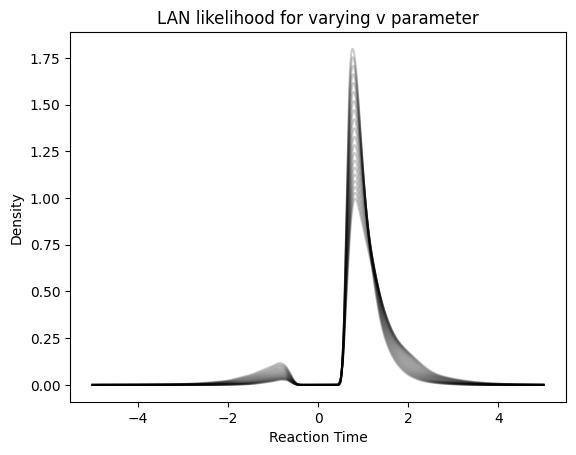

In [27]:
# Loop over parameter configurations to plot
# multiple LAN outputs
for i in np.linspace(1., 2., 20):
    inp_ = np.zeros((2000, 6))
    inp_[:, 0] = i # v parameter --> varies
    inp_[:, 1] = 1.0 # a parameter
    inp_[:, 2] = 0.5 # z parameter
    inp_[:, 3] = 0.5 # ndt parameter
    inp_[:, 4] = np.concatenate([np.linspace(5, 0, 1000),
                                 np.linspace(0, 5, 1000)]) # rt
    inp_[:, 5] = np.concatenate([(-1)*np.ones(1000), np.ones(1000)]) # choices


    plt.plot(inp_[:, 4] * inp_[:, 5], jnp.exp(lan_forward_jitted(inp_)), color = 'black', alpha = 0.2)
    plt.title('LAN likelihood for varying v parameter')
    plt.xlabel('Reaction Time')
    plt.ylabel('Density')

Next we consider the performance of the CPN which, remember, spits out choice probabilities only.
In this plot we vary the $v$ parameter on the x-axis, and show how the choice probabilities produced by the network vary in reponse. This is repeated for multiple levels of the $z$ (or bias) parameter.

Text(0, 0.5, 'P(choice = 1)')

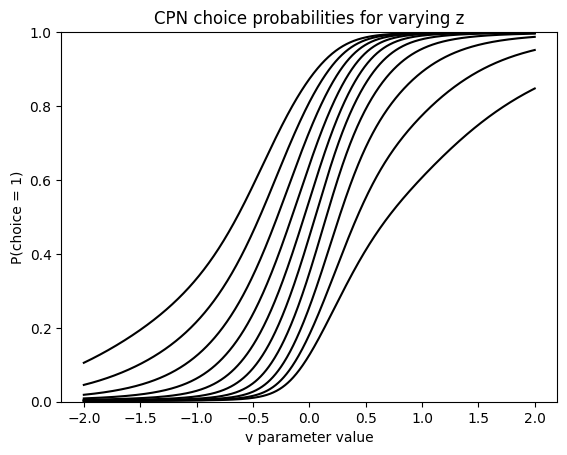

In [28]:
# Vary z in outer loop
for i in np.linspace(0.1, 0.9, 10):
    dat_tmp = np.zeros((1000, 4))
    dat_tmp[:, 0] = np.linspace(-2, 2, 1000) # vary v parameter
    dat_tmp[:, 1] = 2.0 # a
    dat_tmp[:, 2] = i # z
    dat_tmp[:, 3] = 1. # ndt / t
    plt.plot(dat_tmp[:, 0], jnp.exp(cpn_forward_jitted(dat_tmp)), color = 'black')
    
plt.ylim(0, 1)
plt.title('CPN choice probabilities for varying z')
plt.xlabel('v parameter value')
plt.ylabel('P(choice = 1)')

The outputs of the networks behave very regularly which is reassuring. We emphasize however that for serious applications we are better served using a much *larger training data set*. The scale of the simulation run here was chosen to make running the code in this blog-post feasible on local machines in a reasonable amount of time.

### Plug the custom distribution into a PyMC model <a class="anchor" id="pymc_model"></a>

This is finally where the hard work in the previous sections pays off. We are able to *construct our PyMC Model* by assembling the pieces we constructed in the previous sections. First, we instantiate our LAN and CPN based PyMC distributions. Then let us define a function, which takes in a simulated dataset and returns a predefined PyMC model for us. 

In [20]:
# Instantiate LAN based PyMC distribution for DDM
LAN_DDM = DDM.make_ssm_distribution(model=lan_forward,
                                    list_params=["v", "a", "z", "t"],
                                    is_lan = True,
                                    is_cpn = False,
                                    )

# Instantiate CPN based PyMC distribution for DDM
CPN_DDM = DDMCPN.make_ssm_distribution(model=cpn_forward,
                                        list_params = ["v", "a", "z", "t"],
                                        is_lan = False,
                                        is_cpn = True,
                                        )


# CPN_DDM = WFPTCPN.make_ssm_distribution(model=cpn_forward,
#                                         list_params = ["v", "a", "z", "t"],
#                                         is_lan = False,
#                                         is_cpn = True,
#                                         )

In [21]:
def construct_pymc_model(data):
    # Data preprocessing:
    # We expect three columns [rt, choice, condition(go or nogo)]
    # We split the data according to whether the choice is go or nogo
    data_nogo = data.loc[data.choice < 0, :]['is_go_trial'].values
    data_go = data.loc[data.choice > 0, :].values
    
    with pm.Model() as ddm:
        v = pm.Uniform("v", -3.0, 3.0)
        a = pm.Uniform("a", 0.3, 2.5)
        z = pt.constant(0.5)
        t = pm.Uniform("t", 0.0, 2.0)

        go_likelihood = LAN_DDM(
                                name = "gochoices",
                                v = v,
                                a = a,
                                z = z,
                                t = t,
                                observed = data_go,
                               )

        nogo_likelihood = CPN_DDM(
                                  name = "nogochoices",
                                  v = v,
                                  a = a,
                                  z = z,
                                  t = t,
                                  observed = data_nogo,
                                 )
    return ddm

### Inference example <a class="anchor" id="inference_example"></a>

We are nearing the end of this blog-post (promised). All that remains is to simply *try it out*. 
At this point we can simulate some synthetic [Neuroracer](https://www.nature.com/articles/nature12486) experiment data, fire up our newly designed PyMC model and run our MCMC sampler for parameter inference. Then let's simulate...

We pick a set of parameters, and following our modeling assumptions, we apply $v_{NoGo} = (-1)*v_{Go}$ for the trials we assign to the NoGo condition.

In [22]:
# Let's make some data 
from ssms.basic_simulators import simulator
parameters = {'v': 1.0,
              'a': 1.5,
              'z': 0.5,
              't': 0.5}

parameters_go = [parameters[key_] for key_ in parameters.keys()]
parameters_nogo = [parameters[key_] if key_ != 'v' else ((-1)*parameters[key_]) for key_ in parameters.keys()]

# Run simulations for each condition (go, nogo)
sim_go = simulator(theta = parameters_go, model = 'ddm', n_samples = 500) 
sim_nogo = simulator(theta = parameters_nogo, model = 'ddm', n_samples = 500)

# Process data and add a column that signifies whether the trial,
# belongs to a go (1) or nogo (-1) condition
data_go_condition = np.hstack([sim_go['rts'], sim_go['choices'], np.ones((500, 1))])
data_nogo_condition = np.hstack([sim_nogo['rts'], sim_nogo['choices'], (-1)*np.ones((500, 1))])

# Stack the two datasets and turn into DataFrame
data = np.vstack([data_go_condition, data_nogo_condition]).astype(np.float32)
data_pd = pd.DataFrame(data, columns = ['rt', 'choice', 'is_go_trial'])

Our dataset at hand, we can now intiate the PyMC model.

In [23]:
ddm_blog = construct_pymc_model(data_pd)

Let's visualize the model structure. 

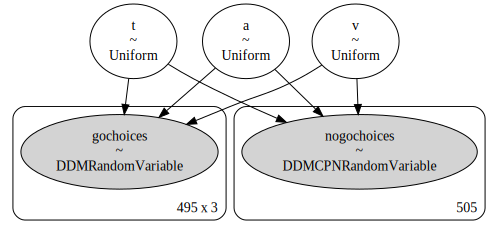

In [24]:
pm.model_to_graphviz(ddm_blog)

Note that we don't fit the $z$ parameter here, which is to avoid known issues with parameter identifiability in case it was included. 

The graphical model nicely illustrates how we handle the Go choices and NoGo choice via separate likelihod objects, while our basic parameters feed into both of these. 

We are now ready to sample...

In [25]:
from pymc.sampling import jax as pmj
with ddm_blog:
    trace_nuts_flax_numpyro = pmj.sample_numpyro_nuts(
            chains=2, draws=2000, tune=500, chain_method="parallel"
            )

/users/afengler/data/software/miniconda3/envs/pymc_ak_lan/lib/python3.9/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


/users/afengler/data/software/miniconda3/envs/pymc_ak_lan/lib/python3.9/site-packages/pymc/sampling/jax.py:623: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:02.705060
Sampling...


/users/afengler/data/software/miniconda3/envs/pymc_ak_lan/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
sample: 100%|████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 126.83it/s, 15 steps of size 4.65e-01. acc. prob=0.94]
/users/afengler/data/software/miniconda3/envs/pymc_ak_lan/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. Se

Sampling time =  0:01:17.890902
Transforming variables...
Transformation time =  0:00:01.462652


Let us finally visualize the posteriors. 

**NOTE:**
The posterior mass here may be somewhat off the mark when comparing to the ground truth parameters. While this hints at a calibration issue, it was conscious approach to trade-off on precision to avoid potentially very long runtimes for this tutorial. We can in general improve the performance of our neural network by training on much more synthetic data (which in real applications is advisable). This would however make running this notebook for illustration purposes cumbersome. 

array([<AxesSubplot: title={'center': 'v'}>,
       <AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 't'}>], dtype=object)

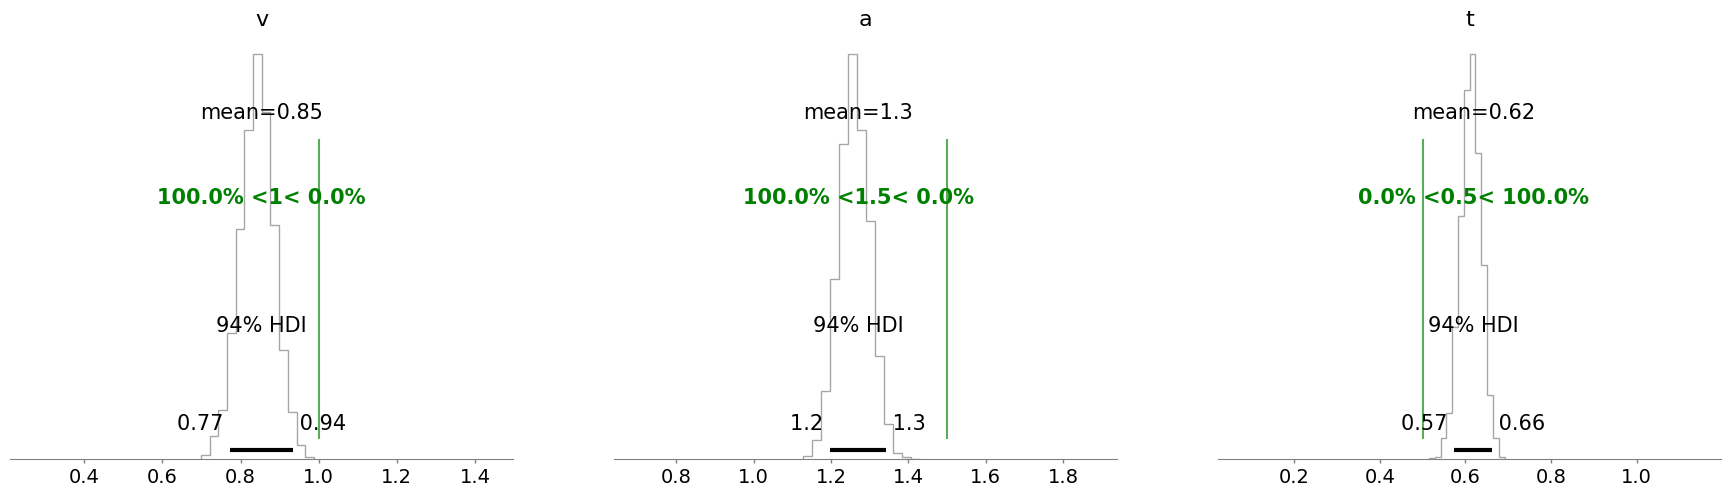

In [27]:
import arviz as az
az.plot_posterior(trace_nuts_flax_numpyro,
                  kind = 'hist',
                  **{'color': 'black', 
                     'histtype': 'step'},
                  ref_val = {'v': [{'ref_val': parameters['v']}],
                             'a': [{'ref_val': parameters['a']}],
                             't': [{'ref_val': parameters['z']}]
                            },
                  ref_val_color = 'green')

A somewhat long but hopefully rewarding story comes to it's end. We hope you may also see some potential in this approach. Many extensions are possible, from the choice of neural network architectures to the structure of the PyMC model a plethora of options arise. If not, we hope that this may at least serve as another take on a tutorial concerning custom distributions in PyMC.

## End
